#Twitter Airline Sentiment Analysis





## Table of contents
1. [Intoroduction](#Intro)
2. [Exploratory Data Analysis](#EDA)
3. [Conventional Representations](#Conventional)
4. [Neural Network Representations](#Neural)
5. [Summary](#Sum)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split



from google.colab import files
from IPython.display import Image
from PIL import Image

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import nltk
nltk.download('punkt');
nltk.download('stopwords');
nltk.download('wordnet');

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense






[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Introduction <a name="Intro"></a>


In this exercise, we will leverage both traditional and neural network approaches in Natural Language Processing (NLP) to perform sentiment analysis on Twitter data. The dataset used, available in Comma-separated values (CSV) format, originates from Kaggle, a data science competition platform. Kaggle sourced the data from Crowdflower's Data for Everyone library and reformatted it for analysis. <br>


The original data collection focused on sentiment analysis related to major U.S. airlines, extracting Twitter data from February 2015. Contributors were tasked with initially categorizing tweets as positive, negative, or neutral. Subsequently, they were required to further classify negative sentiments into specific reasons, such as "late flight" or "rude service." <br>

This dataset serves as the foundation for our sentiment analysis exploration. "Garbage in, garbage out" (GIGO) conveys the idea that if the input data or information is of poor quality or inaccurate, the output or results will also be of poor quality and unreliable. The same rule applies to NLP and we have many ways of converting raw text into a more structured and analyzable format, facilitating subsequent tasks such as sentiment analysis, text classification, or language modeling in NLP. Below are some steps and techniques to process raw text.





> ### **Text processing** <br>  
1. Segmentation: Breaking the entire document down into constituent sentences.
2. Tokenizing: Breaking each sentence into its constituent words and storing them.
3. Stopwords: Removing commonly used words that do not carry significant meaning, such as articles, prepositions, and conjunctions.
4. Stemming: Reducing words to their base or root form by removing suffixes and prefixes. For example, "running" becomes "run."
5. Lemmatization: Similar to stemming, but instead of truncating words, lemmatization converts words to their base form using vocabulary and morphological analysis. For example, "running" becomes "run" and "better" becomes "good."
6. Speed Tagging: Assigning part-of-speech tags to each word in a sentence based on its grammatical role, such as noun, verb, adjective, etc. This process involves using algorithms or models to automatically assign these tags based on contextual and linguistic features.

In addition, there are multiple ways of representing text. The text representation of NLP invovles converting the processed text into a numerical or machine-understandable format that can be used as input for machine learning models and algorithms. We may categorize the techniques for text representation in to two. the conventional count-based method and the representation learning as below.


> ### **Text Representation**  <br>  
1. Count-based or frequency-based methods : Bag-of-Words (BoW), TF-IDF (Term Frequency-Inverse Document Frequency) and one-hot encoding.
2. Representation learning : Word Embeddings (Word2Vec, GloVe), contextual embeddings (BERT, GPT), and other methods that aim to capture semantic relationships.







Below timeline shows the development of representation learning in NLP. Text representation started with some basic - frequence base model such as n-gram back in 1950s and then moved into mroe distribusional method.

In [ ]:
files.upload();

Saving history.jpg to history (1).jpg


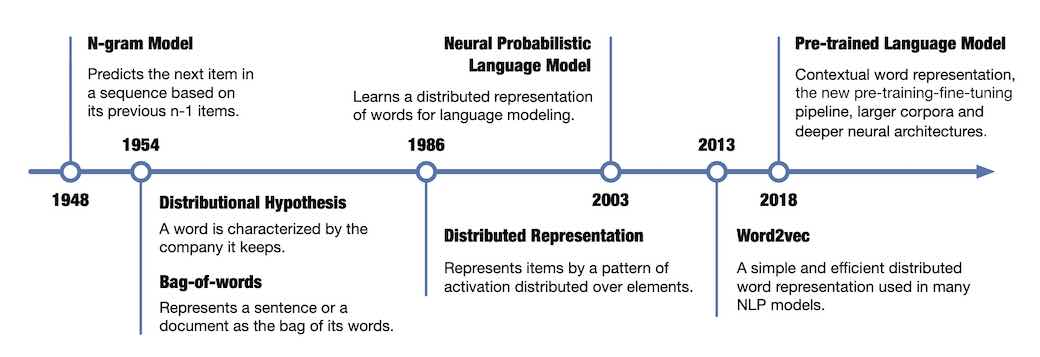

In [ ]:
Image('history.jpg', width=800)

Although there are many text representation options to pick, our foucs fort this project will be on explreoring both classical NLP and Deep learning based NLP. We will compare the accuracy of models.

As such, we will employ CountVectorizer because it is efficient in capturing the frequency of words in a document. CountVectorizer converts a collection of text documents into a matrix of token counts, providing a simple yet effective way to represent the textual data for further analysis


## 2. Exploratory Data Analysis <a name="EDA"></a>
First, let's load the Tweets data and take a quick look on the dataset. At a glance, we see some NaaN values on multiple columns. For our sentiment analysis, we will use the airline_sentiment as the predictor. Let's check if there is any missing values.

In [ ]:
data = pd.read_csv("Tweets.csv")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


As shown below, there is no missing value for airline_sentiment column

In [ ]:

NaaN_data = pd.isnull(data['airline_sentiment'])
data[NaaN_data]


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone


In the earlier sections of the introduction, we discussed various techniques of text processing, such as segmentation and tokenizing. In this EDA (Exploratory Data Analysis) section, we can employ these techniques to create a word cloud, aiming to identify the most common concerns expressed by customers when they leave negative tweets about an airline.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
words = data.dropna(subset=['negativereason'], inplace=True)
words = " ".join(data['negativereason'].astype(str))


In [ ]:
def clean_tokens(data):
  words = " ".join(data)
  tokens = word_tokenize(words)
  tokens = [t.lower() for t in tokens]
  tokens = [t for t in tokens if t not in stopwords.words('english')]
  tokens = [t for t in tokens if t.isalpha()]
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(t) for t in tokens]
  return tokens

In [ ]:
new_tokens = clean_tokens(data['negativereason'])

In [ ]:
bow = " ". join(new_tokens)

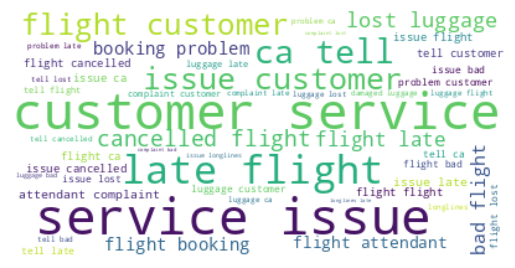

In [ ]:
word_cloud = WordCloud(background_color='white').generate(bow)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Analyzing the word cloud, we observe that customer service and late flights are common subjects of customer complaints. Additionally, we can delve into identifying which airline received the most negative reviews.

In [ ]:
# We have total 7 ailine customers in the dataset
data['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

In [ ]:
#Extract columns that needed for analysis
data_clean = data[["airline_sentiment", "airline", "text"]]

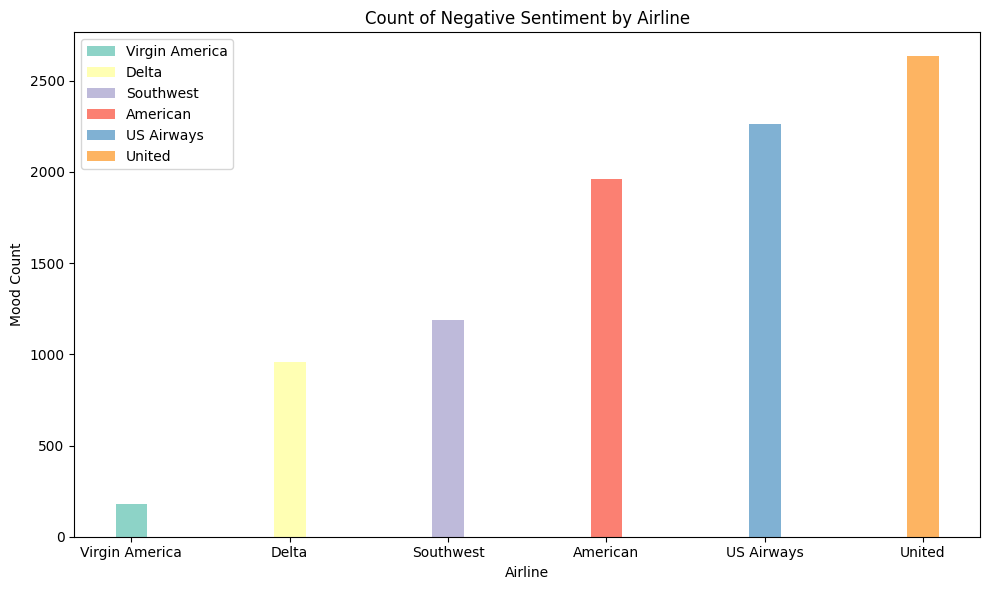

In [ ]:
airlines = data['airline'].unique()
sentiment = 'negative'

# Sort airlines based on the count of the negative sentiment in ascending order
sorted_airlines = data[data['airline_sentiment'] == sentiment].groupby('airline').size().sort_values().index

# Define a color palette with enough distinct colors for the airlines
palette = sns.color_palette('Set3', n_colors=len(airlines))

fig, ax = plt.subplots(figsize=(10, 6))

width = 0.2  # Width of each bar
bar_positions = range(len(sorted_airlines))

for i, airline in enumerate(sorted_airlines):
    count = data[(data['airline'] == airline) & (data['airline_sentiment'] == sentiment)].shape[0]

    # Plot the bars for each airline using the corresponding color from the palette
    ax.bar(bar_positions[i], count, width=width, color=palette[i], label=airline)

ax.set_xticks(bar_positions)
ax.set_xticklabels(sorted_airlines)
ax.set_ylabel('Mood Count')
ax.set_xlabel('Airline')
ax.set_title('Count of Negative Sentiment by Airline')
ax.legend()

plt.tight_layout()
plt.show()


Observing the bar chart above reveals that United has the highest count of negative words, while, in contrast, Virgin America has the lowest.

## Conventional Representations <a name="Conventional"></a>

In this part, we will use the coutervetorizer and then use conventional mdodels such as Naive Bayes, Support Vector Machine, and Logistic Regression to predict the sentiment of the dataset.

In [ ]:
def convert_Sentiment(airline_sentiment	):
    if  airline_sentiment	 == "positive":
        return 2
    elif airline_sentiment	 == "neutral":
        return 1
    elif airline_sentiment	 == "negative":
        return 0

data.sentiment = data.airline_sentiment	.apply(lambda x : convert_Sentiment(x))



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                     Model  Accuracy
0  Multinomial Naive Bayes  0.785519
1   Support Vector Machine  0.801230
2        LogisticRegressio  0.798156


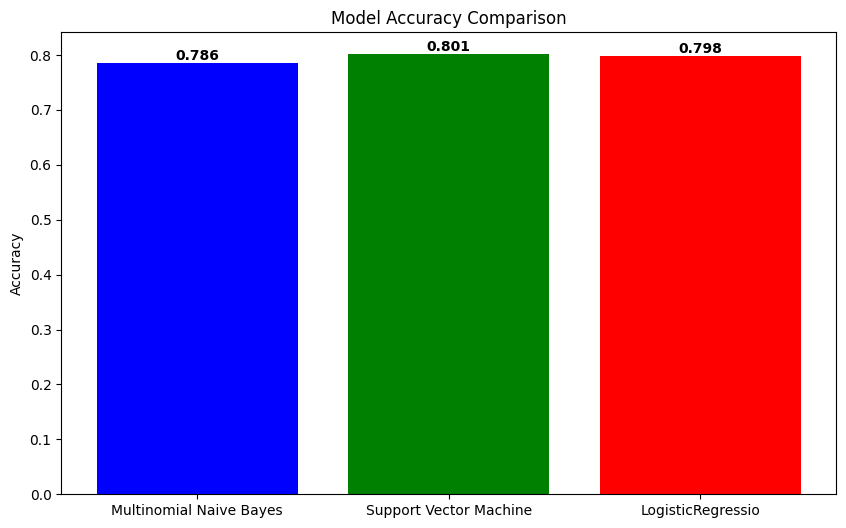

In [ ]:
X = data['text']
y = data['airline_sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CountVectorizer to convert text data to vectors
vect = CountVectorizer()
X_train_vectorized = vect.fit_transform(X_train)

# Create models
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(),
    'LogisticRegressio': LogisticRegression()
}


results = pd.DataFrame()

# Evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_vectorized, y_train)

    # Make predictions
    y_pred = model.predict(vect.transform(X_test))

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Create a DataFrame with the current model results
    model_results = pd.DataFrame({'Model': [model_name], 'Accuracy': [accuracy]})

    # Concatenate along columns
    results = pd.concat([results, model_results], axis=0, ignore_index=True)


print(results)

# Visualize the results using a bar chart with numeric values on top
plt.figure(figsize=(10, 6))
bars = plt.bar(results['Model'], results['Accuracy'], color=['blue', 'green', 'red'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')

# Display numeric values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom', color='black', fontweight='bold')

plt.show()


In the bar chart above, we compare three models: Naive Bayes, Support Vector Machine, and Logistic Regression. It is evident that the Support Vector Machine model delivers the most accurate predictions among the three.

## Neural Network Representations <a name="Neural"></a>

Nueral Network is very powerful machine learing algorithm. However, we also need to ask quseitons first if Nerual Nework is really right applicaiton for a given dataset because Neural Network model does not necesarrly provid the best solutions.

If dataset is not big enough and task is relerlively simple, then it is not really worth of uising NNs. When we use NNs for small dataset, we may overfit to the small daset. Therefore, we may see the high prediction accuracy for tarining but poor prediction accuracy for testing

When there are few input feasures such as tempersture

In [ ]:
%%capture
!pip install tensorflow


In [ ]:
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import SpatialDropout1D, LSTM, Dropout


data.sentiment = data.airline_sentiment	.apply(lambda x : convert_Sentiment(x))


X = data['text']
y = data['airline_sentiment']

model = Sequential()
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


def convert_Sentiment(airline_sentiment	):
    if  airline_sentiment	 == "positive":
        return 2
    elif airline_sentiment	 == "neutral":
        return 1
    elif airline_sentiment	 == "negative":
        return 0


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CountVectorizer to convert text data to vectors
vect = CountVectorizer()
X_train_vectorized = vect.fit_transform(X_train)

# Train the model using the training set and validate on the validation set
model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))


Epoch 1/5


ValueError: ignored

In [ ]:
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import SpatialDropout1D, LSTM, Dropout


def convert_Sentiment(airline_sentiment	):
    if  airline_sentiment	 == "positive":
        return 2
    elif airline_sentiment	 == "neutral":
        return 1
    elif airline_sentiment	 == "negative":
        return 0

data.sentiment = data.airline_sentiment	.apply(lambda x : convert_Sentiment(x))

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_train_padded.shape[1]))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='softmax'))



# Compile the model with categorical cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=15, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred_proba = model.predict(X_test_padded)
y_pred = y_pred_proba.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")





<ipython-input-34-52f480e8c1df>:15: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.sentiment = data.airline_sentiment	.apply(lambda x : convert_Sentiment(x))


Epoch 1/15
293/293 [==============================] - ETA: 0s - loss: 1.2079 - accuracy: 0.6191

ValueError: ignored

In [ ]:
print(X.shape)

(14640,)


## References
  [1] Smith, J., et al. (2020). Title of the Paper. *Journal Name*, Volume(Issue), Page Range.

In [ ]:
#reference :https://www.kaggle.com/code/seungbumlim/twitter-sentiment-analysis-eda-and-ml-dl